<a href="https://colab.research.google.com/github/yashps7/FacialKeypoints_and_ConvexHull/blob/main/FacialKeypoints_and_ConvexHull.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Facial Keypoints Detection and Convex Hull

In [1]:
!nvidia-smi

Sat May 18 17:36:36 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**LOADING DATASET**




(2140, 96, 96, 1)
(2140, 30)


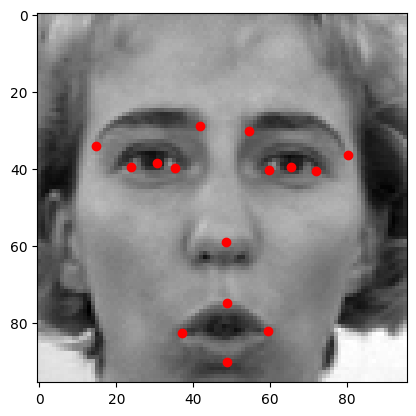

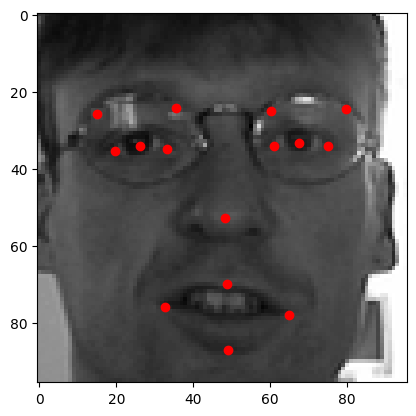

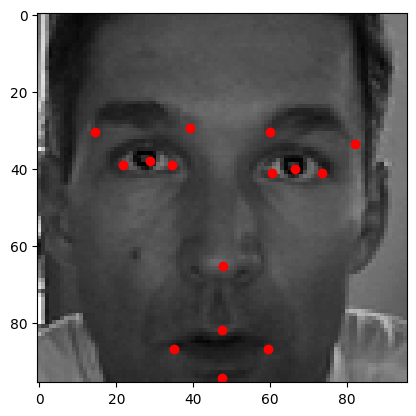

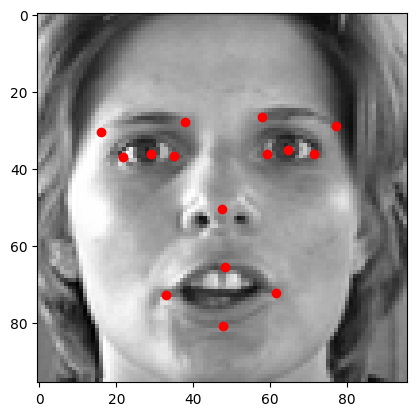

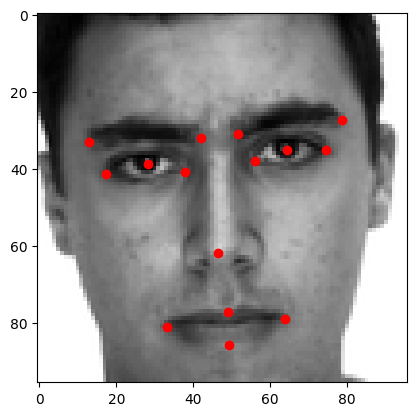

In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import shuffle


def data_loader():

    # Load dataset file
    data_frame = pd.read_csv('/content/drive/MyDrive/dataset2/training.csv')
    data_frame['Image'] = data_frame['Image'].apply(lambda i: np.fromstring(i, sep=' '))
    data_frame = data_frame.dropna()  # Get only the data with 15 keypoints

    # Extract Images pixel values
    imgs_array = np.vstack(data_frame['Image'].values)/ 255.0
    imgs_array = imgs_array.astype(np.float32)    # Normalize, target values to (0, 1)
    imgs_array = imgs_array.reshape(-1, 96, 96, 1)

    # Extract labels (key point cords)
    labels_array = data_frame[data_frame.columns[:-1]].values
    labels_array = (labels_array - 48) / 48    # Normalize, target co-ordinates to (-1, 1)
    labels_array = labels_array.astype(np.float32)

    # shuffle the train data
    imgs_array, labels_array = shuffle(imgs_array, labels_array, random_state=9)

    return imgs_array, labels_array


# This snippet is to verify data
imgs, labels = data_loader()
print(imgs.shape)
print(labels.shape)

image_indexes = [700, 400, 1700, 234, 200]
for n in image_indexes:
  labels[n] = (labels[n]*48)+48
  image = np.squeeze(imgs[n])
  plt.imshow(image, cmap='gray')
  plt.plot(labels[n][::2], labels[n][1::2], 'ro')
  plt.show()

**USING CNN AND TRAINING DATA**

In [4]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D, Activation, BatchNormalization
from keras.layers import Flatten, Dense
from keras import optimizers
from keras.callbacks import ModelCheckpoint, History

# Main model
def the_model():
    model = Sequential()

    model.add(Conv2D(16, (3,3), padding='same', activation='relu', input_shape=X_train.shape[1:])) # Input shape: (96, 96, 1)
    model.add(MaxPooling2D(pool_size=2))

    model.add(Conv2D(32, (3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))

    # Convert all values to 1D array
    model.add(Flatten())

    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(30))

    return model


X_train, y_train = data_loader()
print("Training datapoint shape: X_train.shape:{}".format(X_train.shape))
print("Training labels shape: y_train.shape:{}".format(y_train.shape))


epochs = 100
batch_size = 16

model = the_model()
hist = History()

checkpointer = ModelCheckpoint(filepath='checkpoint1.hdf5',
                               verbose=2, save_best_only=True)
model.summary()
# Compile Model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

model_fit = model.fit(X_train, y_train, validation_split=0.2, epochs=epochs, batch_size=batch_size, callbacks=[checkpointer, hist], verbose=2)

model.save('model1.h5')


Training datapoint shape: X_train.shape:(2140, 96, 96, 1)
Training labels shape: y_train.shape:(2140, 30)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 48, 48, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 24, 24, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 64)        18496     
                

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss improved from 0.00496 to 0.00473, saving model to checkpoint1.hdf5
107/107 - 1s - loss: 0.0061 - accuracy: 0.6536 - val_loss: 0.0047 - val_accuracy: 0.7126 - 867ms/epoch - 8ms/step
Epoch 3/100

Epoch 3: val_loss improved from 0.00473 to 0.00459, saving model to checkpoint1.hdf5
107/107 - 1s - loss: 0.0054 - accuracy: 0.6577 - val_loss: 0.0046 - val_accuracy: 0.7126 - 859ms/epoch - 8ms/step
Epoch 4/100

Epoch 4: val_loss improved from 0.00459 to 0.00455, saving model to checkpoint1.hdf5
107/107 - 1s - loss: 0.0049 - accuracy: 0.6741 - val_loss: 0.0045 - val_accuracy: 0.7150 - 861ms/epoch - 8ms/step
Epoch 5/100

Epoch 5: val_loss improved from 0.00455 to 0.00397, saving model to checkpoint1.hdf5
107/107 - 1s - loss: 0.0046 - accuracy: 0.6869 - val_loss: 0.0040 - val_accuracy: 0.7173 - 694ms/epoch - 6ms/step
Epoch 6/100

Epoch 6: val_loss improved from 0.00397 to 0.00330, saving model to checkpoint1.hdf5
107/107 - 1s - loss: 0.0041 - accuracy: 0.6898 - val_loss: 0.0033 

**LOAD MODEL -> INPUT IMAGE -> DETECT FACE -> DETERMINE EXPRESSION -> CONVEX HULL**

1/1 [==============================] - 0s 184ms/step


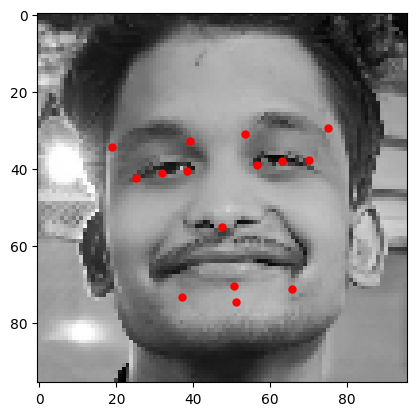

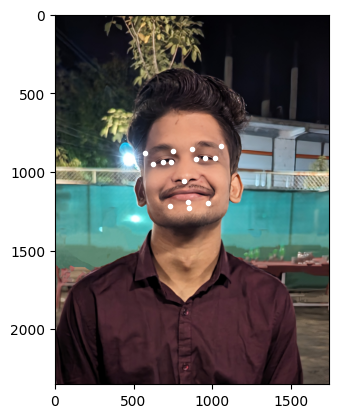

28.646162607751375
 
This person is not smiling :(
 
 
The Convex Hull of the keypoints is: 
1/1 [==============================] - 0s 20ms/step


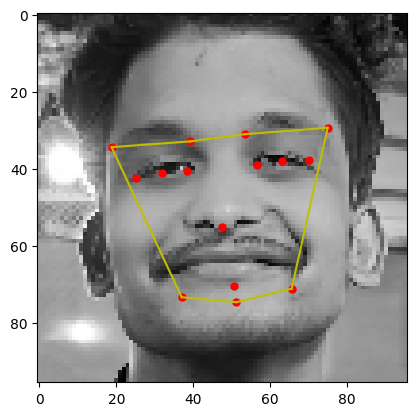

In [6]:
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import time
import math
from scipy.spatial import ConvexHull, convex_hull_plot_2d

# Load the saved model
from keras.models import load_model
model = load_model('model1.h5')  # <-- Saved model path


def detect_points(face_img):
    me  = np.array(face_img)/255
    x_test = np.expand_dims(me, axis=0)
    x_test = np.expand_dims(x_test, axis=3)

    y_test = model.predict(x_test)
    label_points = (np.squeeze(y_test)*48)+48

    return label_points

# Load haarcascade
#face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

dimensions = (96, 96)

# Enter the path to your test image
img = cv2.imread('/content/drive/MyDrive/PXL_20240307_161618009~3.jpg')

default_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

faces = face_cascade.detectMultiScale(gray_img, 1.3, 5)

faces_img = np.copy(gray_img)

plt.rcParams["axes.grid"] = False


all_x_cords = []
all_y_cords = []
red_x_cords = []
red_y_cords = []

for i, (x,y,w,h) in enumerate(faces):

    h += 10
    w += 10
    x -= 5
    y -= 5

    just_face = cv2.resize(gray_img[y:y+h,x:x+w], dimensions)
    cv2.rectangle(faces_img,(x,y),(x+w,y+h),(255,0,0),1)

    scale_val_x = w/96
    scale_val_y = h/96

    label_point = detect_points(just_face)
    red_x_cords.append(label_point[::2])
    red_y_cords.append(label_point[1::2])
    all_x_cords.append((label_point[::2]*scale_val_x)+x)
    all_y_cords.append((label_point[1::2]*scale_val_y)+y)

    plt.imshow(just_face, cmap='gray')
    plt.plot(label_point[::2], label_point[1::2], 'ro', markersize=5)
    plt.show()


plt.imshow(default_img)
plt.plot(all_x_cords, all_y_cords, 'wo',  markersize=3)
plt.show()

scale_val_x = w/96
scale_val_y = h/96

def getDistance():

  x1 = ((all_x_cords[0][12]/scale_val_x)-x)
  y1 = ((all_y_cords[0][12]/scale_val_y)-y)

  x2 = ((all_x_cords[0][11]/scale_val_x)-x)
  y2 = ((all_y_cords[0][11]/scale_val_y)-y)

  d = ((x2 - x1)**2) + ((y2 - y1)**2)
  distance = math.sqrt(d)
  return distance

def smileOrNeutral(d):
  if d >= 30.0:
    print(" ")
    print("This person is smiling :D")
    print(" ")
  else:
    print(" ")
    print("This person is not smiling :(")
    print(" ")

d = getDistance()
print(d)
smileOrNeutral(d)


def plotLines(p, q):
  a = [red_x_cords[0][p], red_x_cords[0][q]]
  b = [red_y_cords[0][p], red_y_cords[0][q]]
  return a, b

def convexHull():
  redPoints = detect_points(just_face)
  plt.imshow(just_face, cmap='gray')
  plt.plot(label_point[::2], label_point[1::2], 'ro', markersize=5)

  leftEyeLineX, leftEyeLineY = plotLines(8, 9)
  rightEyeLineX, rigthEyeLineY = plotLines(6, 7)
  rightX, rightY = plotLines(7, 11)
  leftX, leftY = plotLines(9, 12)
  rightMouthX, rightMouthY = plotLines(11, 14)
  leftMouthX, leftMouthY = plotLines(12, 14)
  centreX, centreY = plotLines(6, 8)
  plt.plot(leftEyeLineX, leftEyeLineY, 'y')
  plt.plot(rightEyeLineX, rigthEyeLineY, 'y')
  plt.plot(rightX, rightY, 'y')
  plt.plot(leftX, leftY, 'y')
  plt.plot(rightMouthX, rightMouthY, 'y')
  plt.plot(leftMouthX, leftMouthY, 'y')
  plt.plot(centreX, centreY, 'y')
  plt.show()

print(" ")
print("The Convex Hull of the keypoints is: ")
convexHull()